In [2]:
%%capture
!pip install statsforecast

In [32]:
##########
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA
)
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

# Set environment variable
os.environ['NIXTLA_ID_AS_COL'] = '1'

##########
# Read the data
df = pd.read_csv("https://raw.githubusercontent.com/2002arnavsinha/Dow-Jones-Dataset-Nixtla-Playground/main/dow_jones_index.data", delimiter=",")

df_nixtla = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

In [33]:
df_nixtla

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0
...,...,...,...
373367,H99,744,24039.0
373368,H99,745,22946.0
373369,H99,746,22217.0
373370,H99,747,21416.0


In [34]:
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


In [35]:
df_nixtla.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [36]:
df.dtypes

,0
quarter,int64
stock,object
date,object
open,object
high,object
low,object
close,object
volume,int64
percent_change_price,float64
percent_change_volume_over_last_wk,float64


In [37]:
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


In [39]:
import pandas as pd

# Assuming your DataFrame is named df
# Assuming 'df' is already loaded with your data

# List of columns to convert (excluding 'date', 'stock', and any other non-numeric columns)
columns_to_convert = df.columns.drop(['quarter','stock', 'date'])

# Function to convert comma-separated decimals to dots
def comma_to_dot(x):
    return x.replace(',', '.') if isinstance(x, str) else x

# Apply the conversion column by column
for col in columns_to_convert:
    df[col] = df[col].apply(comma_to_dot).replace({'\$': '', ',': ''}, regex=True).astype(float)

# Display the converted DataFrame
print(df.head())


   quarter stock       date   open   high    low  close       volume  \
0        1    AA   1/7/2011  15.82  16.72  15.78  16.42  239655616.0   
1        1    AA  1/14/2011  16.71  16.71  15.64  15.97  242963398.0   
2        1    AA  1/21/2011  16.19  16.38  15.60  15.79  138428495.0   
3        1    AA  1/28/2011  15.87  16.63  15.82  16.13  151379173.0   
4        1    AA   2/4/2011  16.18  17.39  16.18  17.14  154387761.0   

   percent_change_price  percent_change_volume_over_last_wk  \
0               3.79267                                 NaN   
1              -4.42849                            1.380223   
2              -2.47066                          -43.024959   
3               1.63831                            9.355500   
4               5.93325                            1.987452   

   previous_weeks_volume  next_weeks_open  next_weeks_close  \
0                    NaN            16.71             15.97   
1            239655616.0            16.19             15.79   

In [10]:
import pandas as pd

# Assuming your DataFrame is named df

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# Display the updated DataFrame
print(df.head())


   quarter stock       date   open   high    low  close       volume  \
0        1    AA 2011-01-07  15.82  16.72  15.78  16.42  239655616.0   
1        1    AA 2011-01-14  16.71  16.71  15.64  15.97  242963398.0   
2        1    AA 2011-01-21  16.19  16.38  15.60  15.79  138428495.0   
3        1    AA 2011-01-28  15.87  16.63  15.82  16.13  151379173.0   
4        1    AA 2011-02-04  16.18  17.39  16.18  17.14  154387761.0   

   percent_change_price  percent_change_volume_over_last_wk  \
0               3.79267                                 NaN   
1              -4.42849                            1.380223   
2              -2.47066                          -43.024959   
3               1.63831                            9.355500   
4               5.93325                            1.987452   

   previous_weeks_volume  next_weeks_open  next_weeks_close  \
0                    NaN            16.71             15.97   
1            239655616.0            16.19             15.79   

In [40]:
import pandas as pd

# Assuming your DataFrame is named df

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# Rename the 'date' column to 'ds' for consistency
df.rename(columns={'date': 'ds'}, inplace=True)

# Set the 'ds' column as the index
df.set_index("ds", inplace=True)

# Display the updated DataFrame
print(df.head())


            quarter stock   open   high    low  close       volume  \
ds                                                                   
2011-01-07        1    AA  15.82  16.72  15.78  16.42  239655616.0   
2011-01-14        1    AA  16.71  16.71  15.64  15.97  242963398.0   
2011-01-21        1    AA  16.19  16.38  15.60  15.79  138428495.0   
2011-01-28        1    AA  15.87  16.63  15.82  16.13  151379173.0   
2011-02-04        1    AA  16.18  17.39  16.18  17.14  154387761.0   

            percent_change_price  percent_change_volume_over_last_wk  \
ds                                                                     
2011-01-07               3.79267                                 NaN   
2011-01-14              -4.42849                            1.380223   
2011-01-21              -2.47066                          -43.024959   
2011-01-28               1.63831                            9.355500   
2011-02-04               5.93325                            1.987452   

    

In [41]:
df.head()

,quarter,stock,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
ds,,,,,,,,,,,,,,,
2011-01-07,1,AA,15.82,16.72,15.78,16.42,239655616.0,3.79267,NaN,NaN,16.71,15.97,-4.428490,26.0,0.182704
2011-01-14,1,AA,16.71,16.71,15.64,15.97,242963398.0,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19.0,0.187852
2011-01-21,1,AA,16.19,16.38,15.60,15.79,138428495.0,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12.0,0.189994
2011-01-28,1,AA,15.87,16.63,15.82,16.13,151379173.0,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5.0,0.185989
2011-02-04,1,AA,16.18,17.39,16.18,17.14,154387761.0,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97.0,0.175029


In [42]:
df = df.stack()

In [43]:
df = df.reset_index()

In [44]:
df.head()

,ds,level_1,0
0,2011-01-07,quarter,1
1,2011-01-07,stock,AA
2,2011-01-07,open,15.82
3,2011-01-07,high,16.72
4,2011-01-07,low,15.78


In [45]:
df.columns = ["ds", "unique_id", "y"]
df = df[["unique_id", "ds", "y"]]

In [17]:
df.sort_values(["unique_id","ds"])

,unique_id,ds,y
4,close,2011-01-07,1.642000e+01
170,close,2011-01-07,4.436000e+01
336,close,2011-01-07,6.938000e+01
502,close,2011-01-07,1.425000e+01
668,close,2011-01-07,9.373000e+01
...,...,...,...
9703,volume,2011-06-24,2.095945e+07
9885,volume,2011-06-24,2.077522e+07
10067,volume,2011-06-24,8.237523e+07
10249,volume,2011-06-24,7.560255e+07


In [46]:
df = df.groupby('unique_id').apply(lambda x: x.resample('W', on='ds').last())

In [47]:
df = df.drop(columns='unique_id').reset_index()

In [48]:
Y_df = df.copy()

In [49]:
df

,unique_id,ds,y
0,close,2011-01-09,75.59
1,close,2011-01-16,77.84
2,close,2011-01-23,78.98
3,close,2011-01-30,78.99
4,close,2011-02-06,83.28
...,...,...,...
368,volume,2011-05-29,68230855.0
369,volume,2011-06-05,78616295.0
370,volume,2011-06-12,92380844.0
371,volume,2011-06-19,100521400.0


In [52]:
Y_df_clean = Y_df.dropna(subset=['y'])
Y_df['y'].fillna(method='ffill', inplace=True)



<ipython-input-52-ed36fc240121>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Y_df['y'].fillna(method='ffill', inplace=True)


In [53]:
print(Y_df_clean.head())
print(Y_df_clean.isna().sum())  # Check for any remaining NaN values


  unique_id         ds      y
0     close 2011-01-09  75.59
1     close 2011-01-16  77.84
2     close 2011-01-23  78.98
3     close 2011-01-30  78.99
4     close 2011-02-06  83.28
unique_id    0
ds           0
y            0
dtype: int64


In [57]:
Y_df['y'] = pd.to_numeric(Y_df['y'], errors='coerce')
print(Y_df['y'].isna().sum())


25


In [58]:
Y_df.dropna(subset=['y'], inplace=True)  # This will drop rows with NaN in 'y'


In [54]:
from statsforecast import StatsForecast


(348, 3)
  unique_id         ds      y
0     close 2011-01-09  75.59
1     close 2011-01-16  77.84
2     close 2011-01-23  78.98
3     close 2011-01-30  78.99
4     close 2011-02-06  83.28
Index(['unique_id', 'ds', 'y'], dtype='object')
['close' 'days_to_next_dividend' 'high' 'low' 'next_weeks_close'
 'next_weeks_open' 'open' 'percent_change_next_weeks_price'
 'percent_change_price' 'percent_change_volume_over_last_wk'
 'percent_return_next_dividend' 'previous_weeks_volume' 'quarter' 'volume']
unique_id
close                                 25
days_to_next_dividend                 25
high                                  25
low                                   25
next_weeks_close                      25
next_weeks_open                       25
open                                  25
percent_change_next_weeks_price       25
percent_change_price                  25
percent_change_volume_over_last_wk    24
percent_return_next_dividend          25
previous_weeks_volume                 24

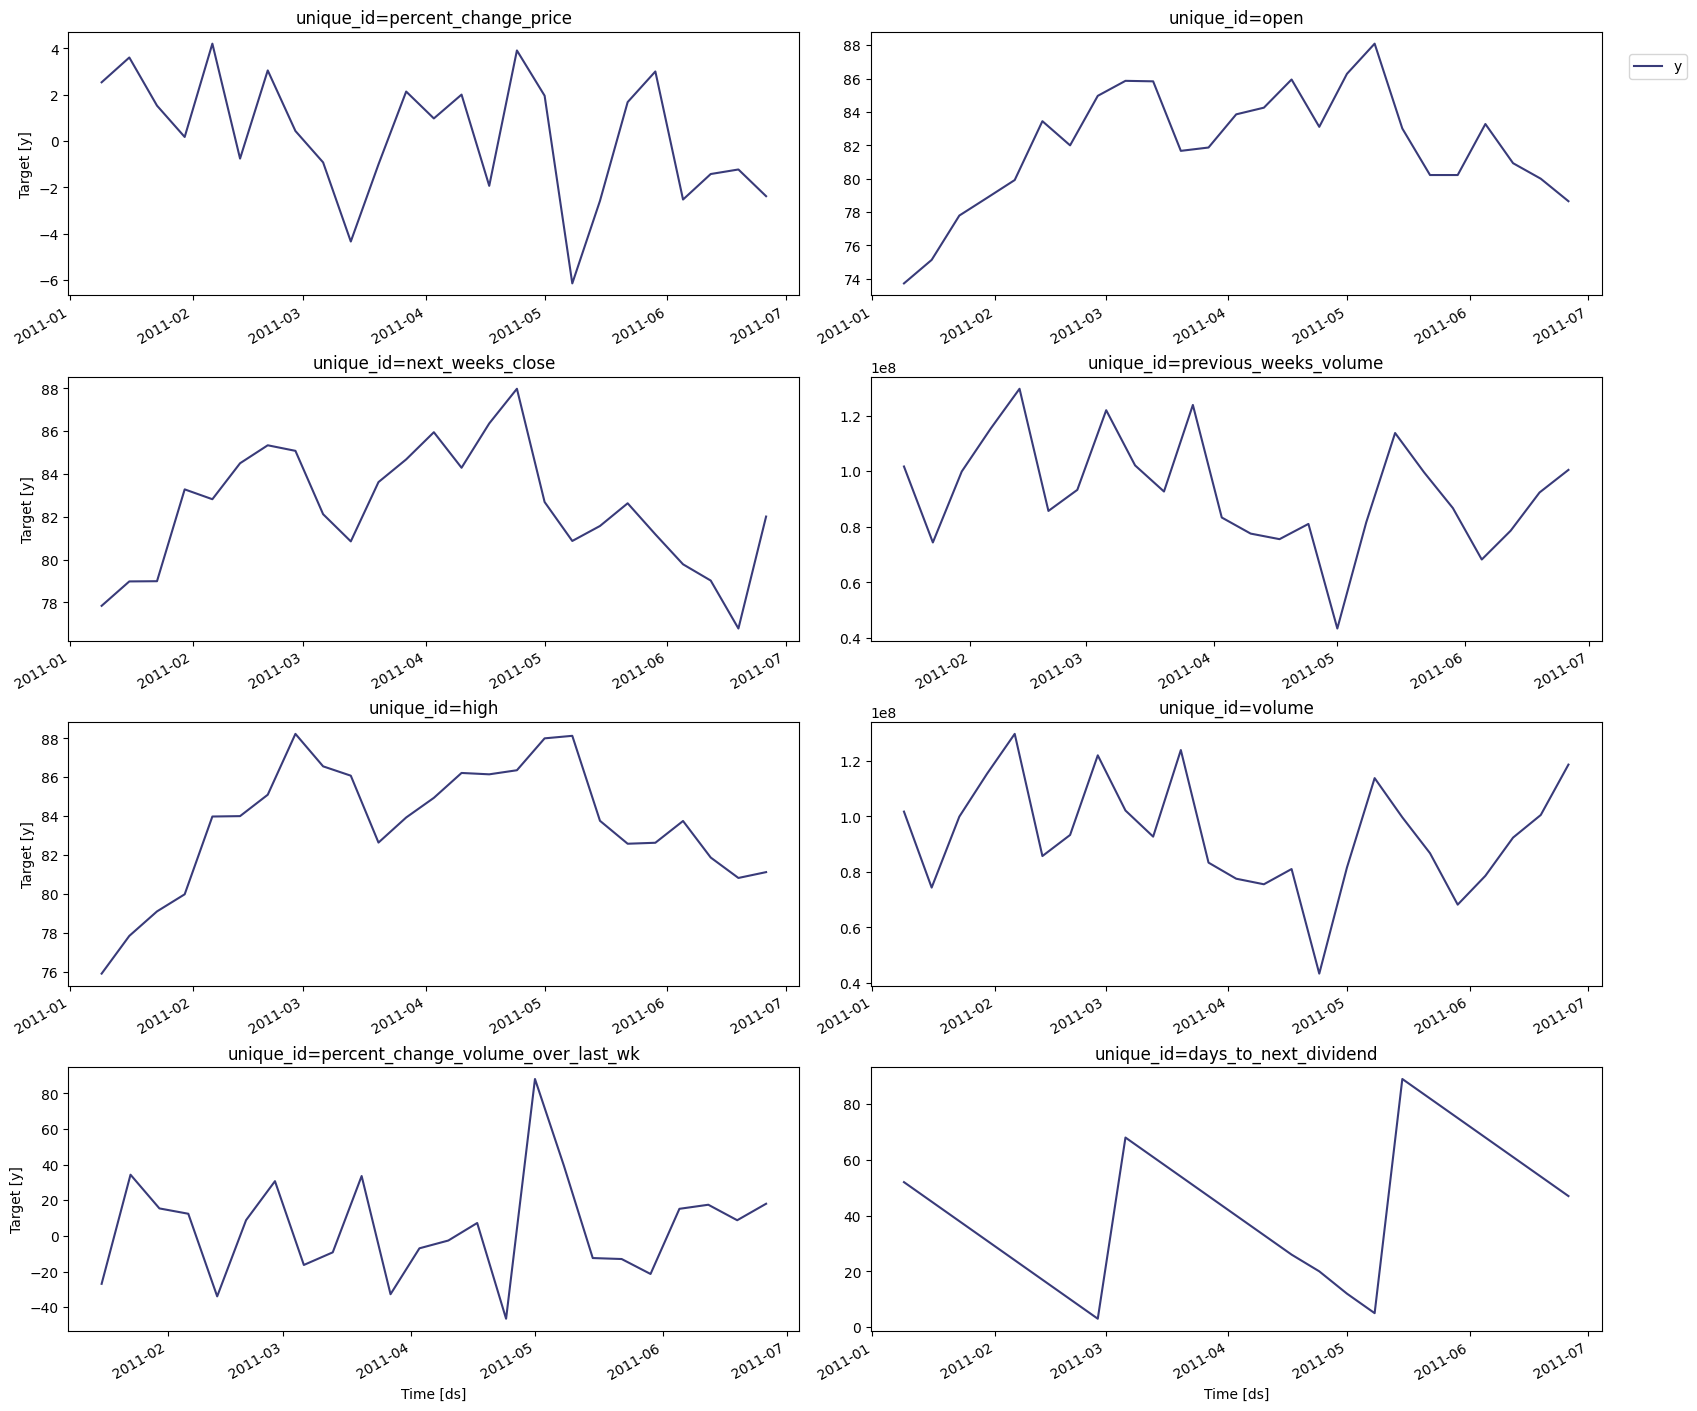

In [59]:
import pandas as pd

# Example DataFrame check
print(Y_df.shape)
print(Y_df.head())

# Ensure columns are correct
print(Y_df.columns)

# Check unique IDs
print(Y_df['unique_id'].unique())

# Check if the groups have enough rows
print(Y_df.groupby('unique_id').size())

# Verify if there's data to plot
print(Y_df.head())

# Assuming `StatsForecast.plot` expects 'ds' and 'y' columns:
Y_df.rename(columns={'date': 'ds', 'value': 'y'}, inplace=True)

# Attempt to plot
StatsForecast.plot(Y_df)


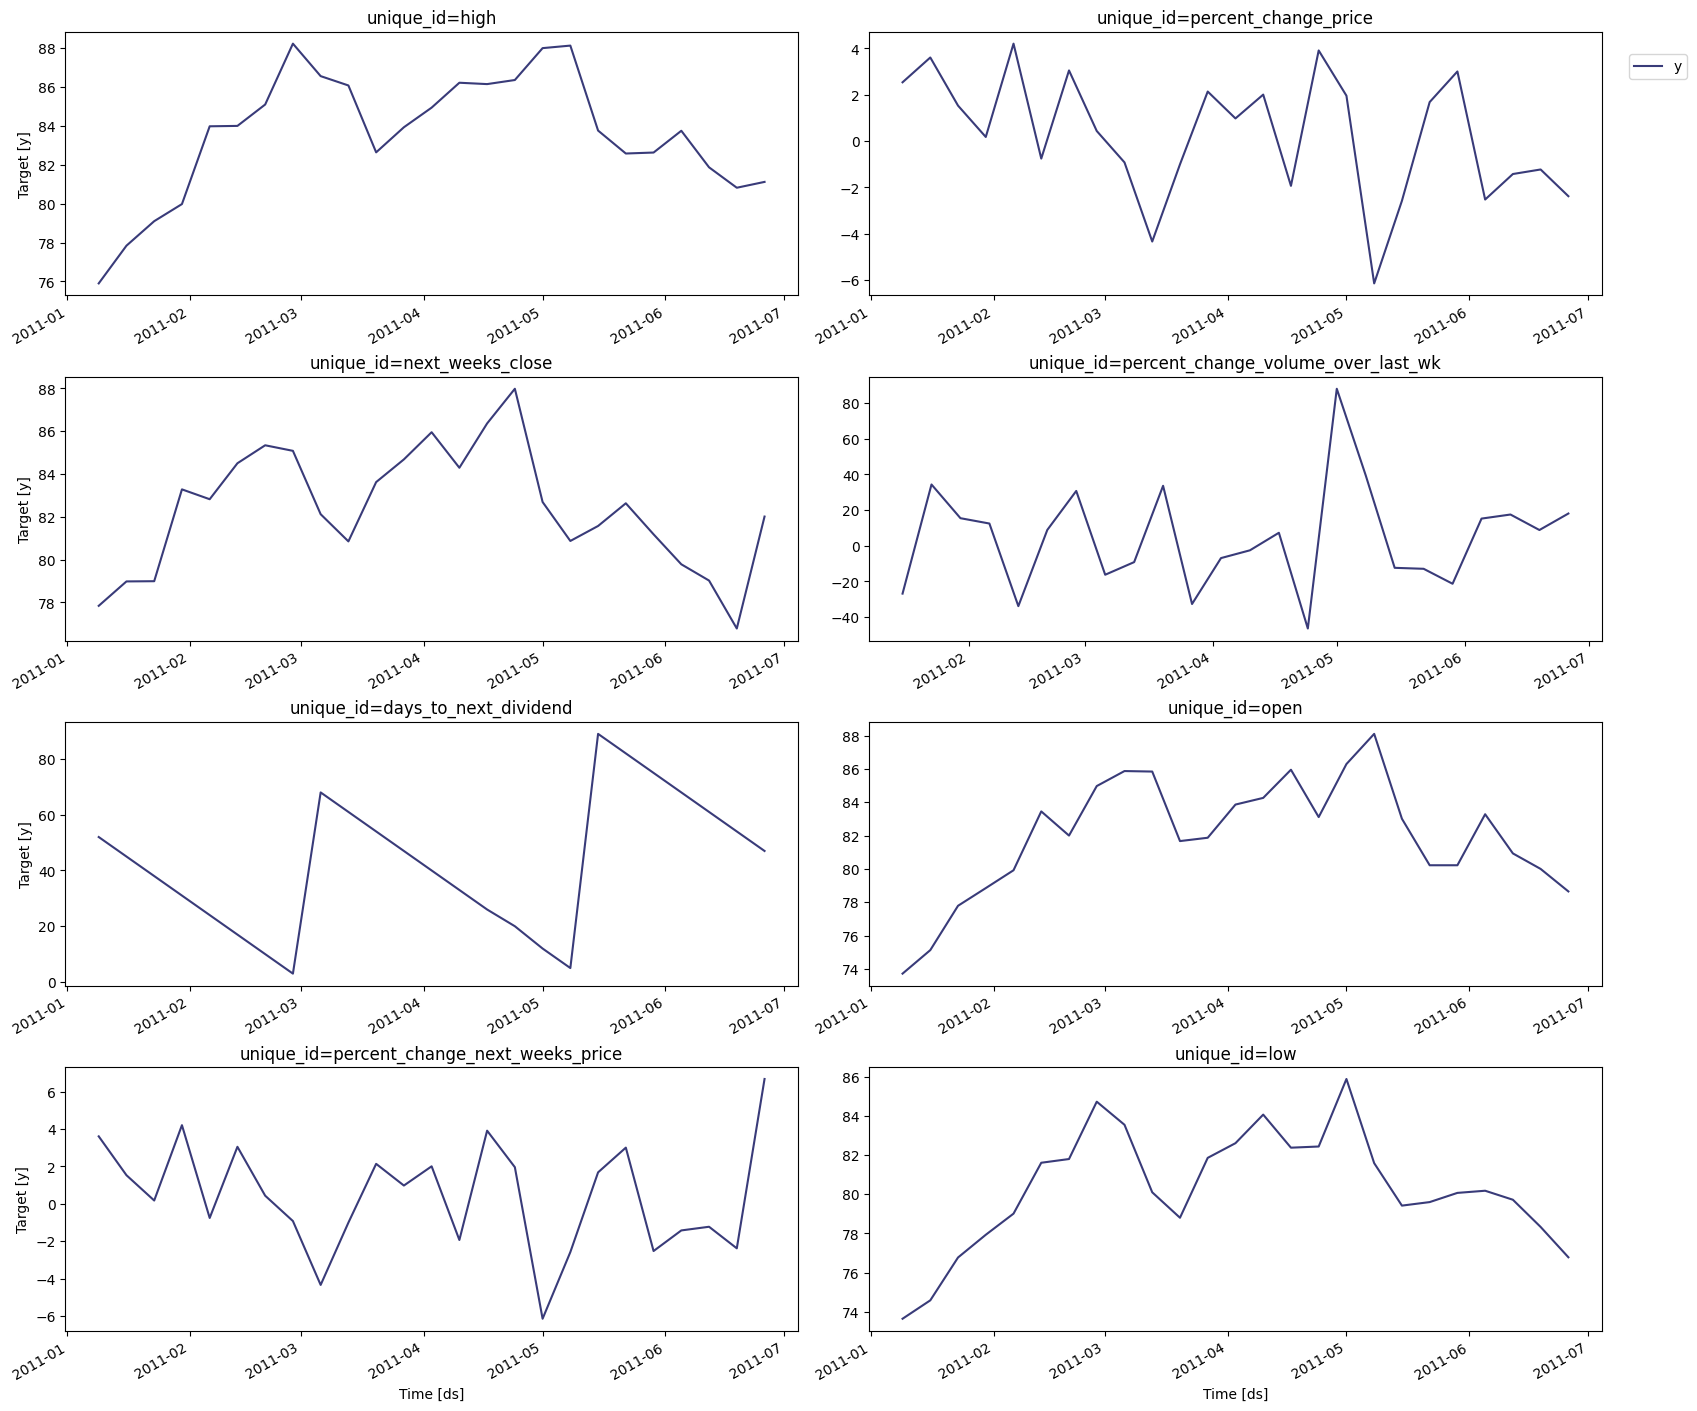

In [60]:
# Select subset of data
uids = Y_df['unique_id'].unique()[:10]
Y_df = Y_df.query('unique_id in @uids')
Y_df = Y_df.groupby('unique_id').tail(7 * 24)

##########
# Explore data
StatsForecast.plot(Y_df)



1. HoltWinters: Triple exponential smoothing, good for data with both trend and seasonality.
1. Croston: Designed for intermittent demand forecasting.
1. SeasonalNaive(season_length=24): Uses the value from the same time in the previous season. The season_length=24 suggests hourly data with daily seasonality.
1. HistoricAverage: Uses the mean of all historical data points.
1. DOT (Dynamic Optimized Theta): A variant of the Theta method, good for data with seasonality.

In [61]:
df.head()

,unique_id,ds,y
0,close,2011-01-09,75.59
1,close,2011-01-16,77.84
2,close,2011-01-23,78.98
3,close,2011-01-30,78.99
4,close,2011-02-06,83.28


In [63]:
##########
# Define models
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=52),  # Updated for weekly data with annual seasonality
    HistoricAverage(),
    DOT(season_length=52),  # Updated for weekly data with annual seasonality
    # AutoARIMA(season_length=52) ## slightly slow, ignoring for now
]

# The season_length=52 refers to weekly data with annual seasonality.

# Instantiate StatsForecast
sf = StatsForecast(
    models=models,
    freq='W',  # Updated for weekly frequency
    fallback_model=SeasonalNaive(season_length=4),  # Adjust as necessary, fallback seasonality
    n_jobs=-1,
)


Up to here is good, you can finish here

In [65]:
# Generate forecasts
forecasts_df = sf.forecast(df=Y_df, h=12, level=[90])


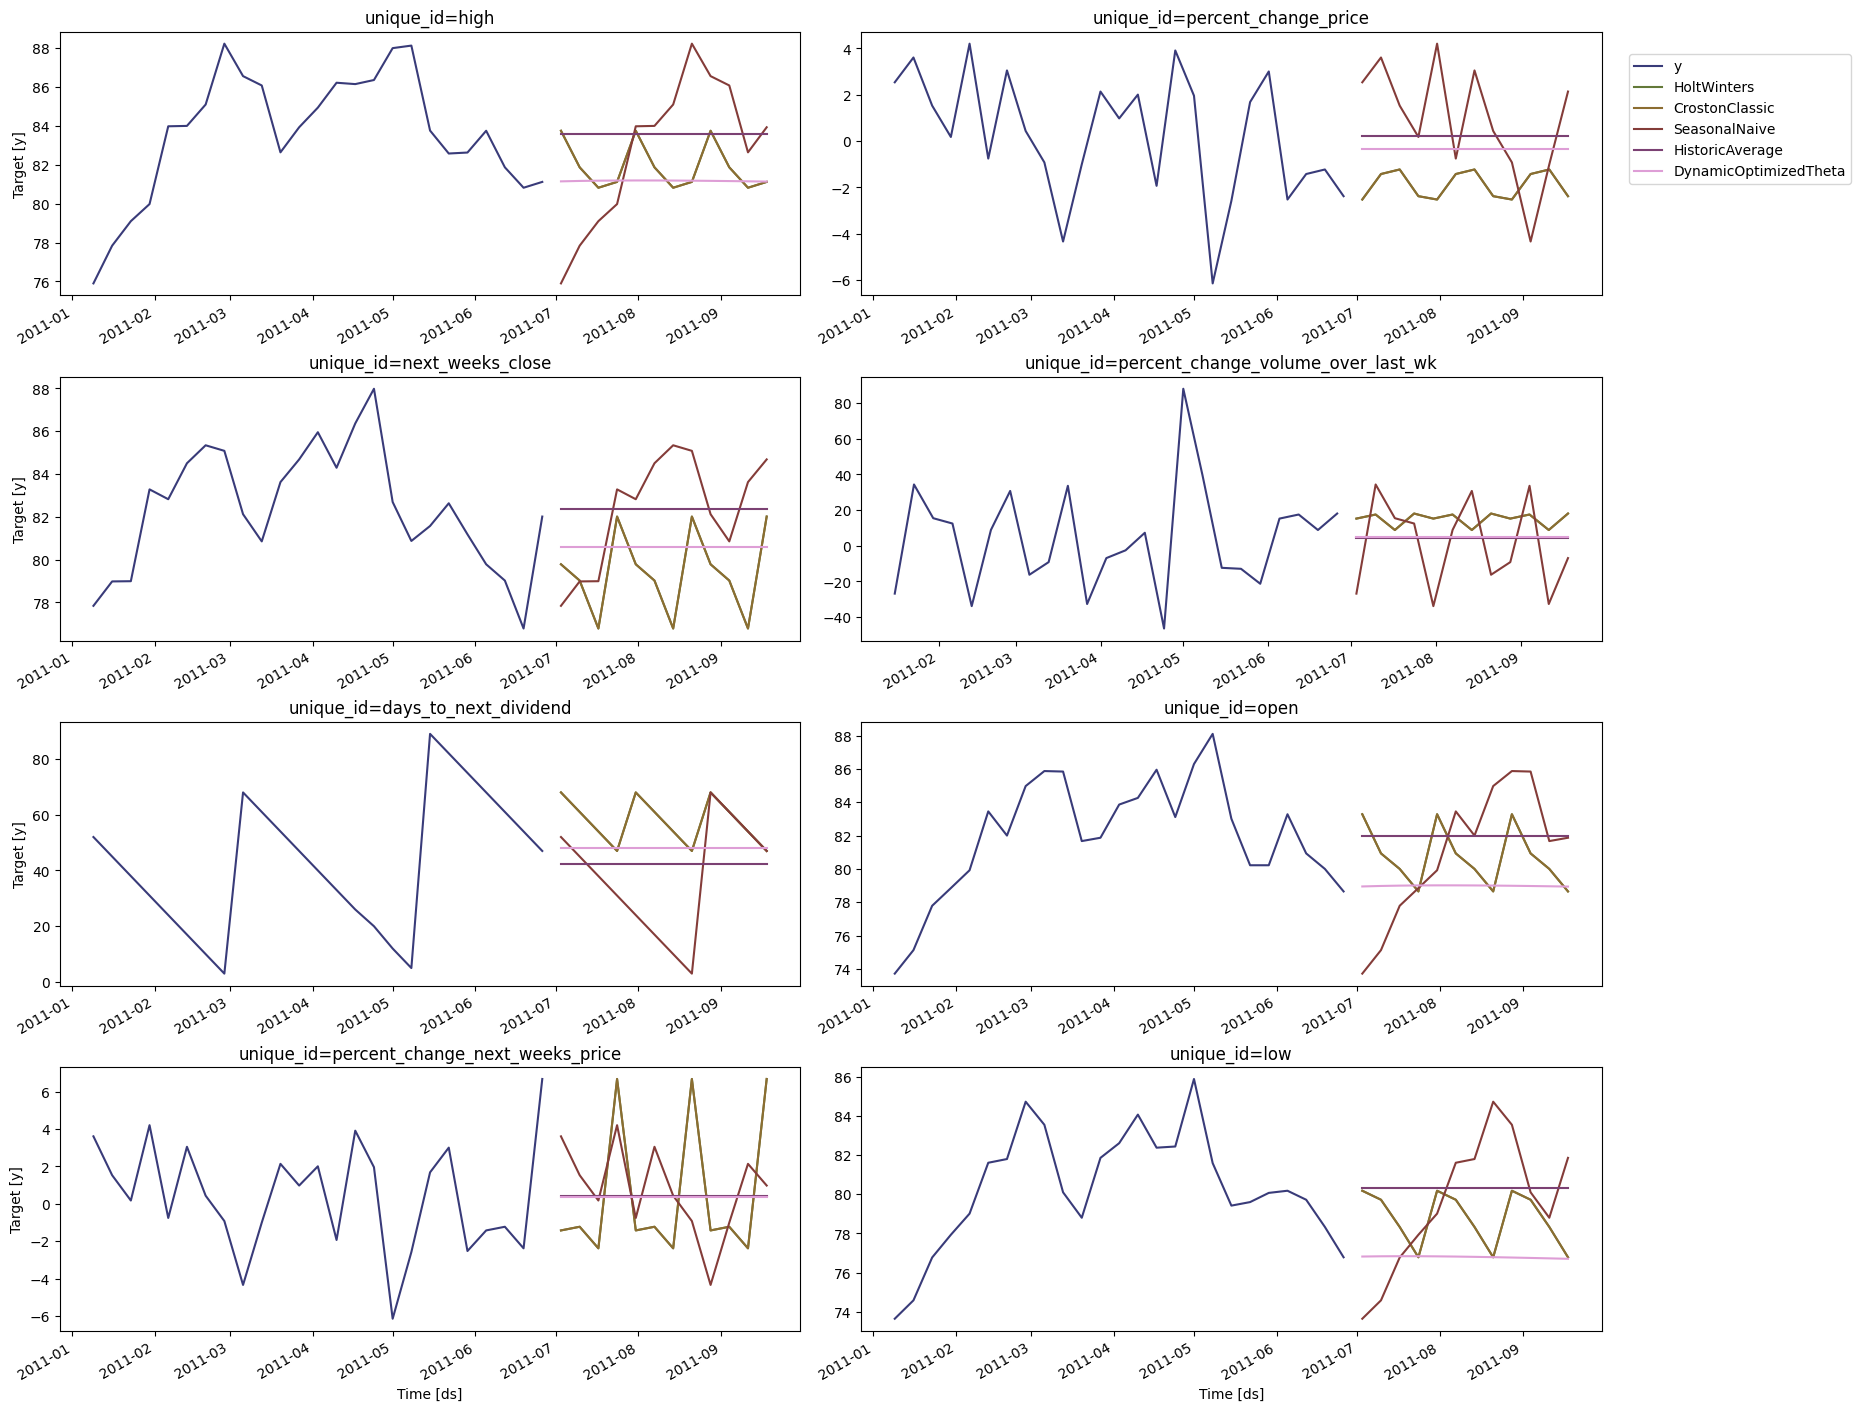

In [66]:
##########
# Plot forecasts
sf.plot(Y_df, forecasts_df)

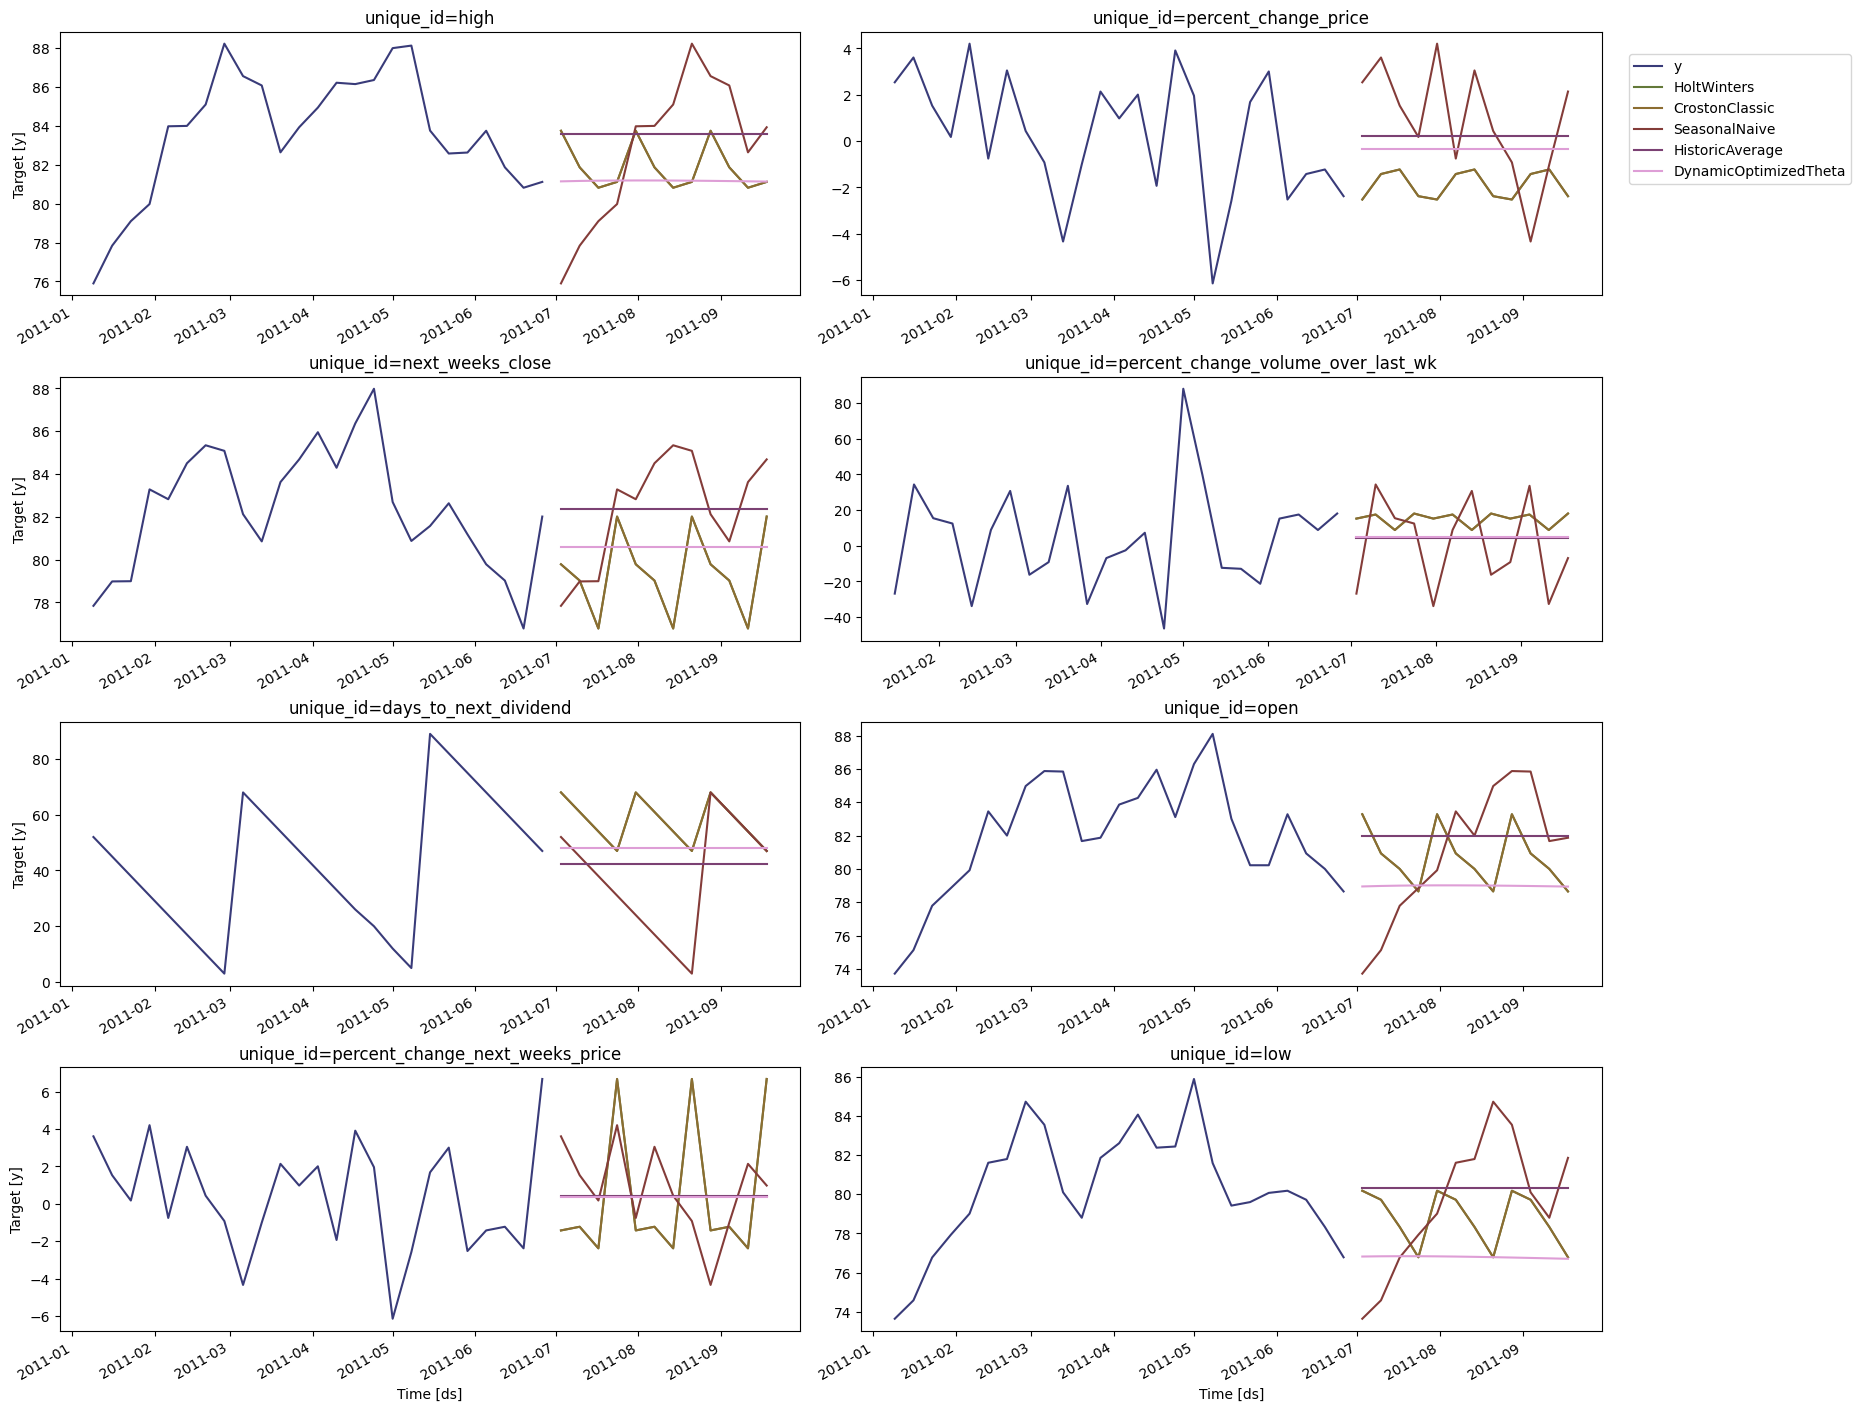

In [67]:
##########
# Plot forecasts
sf.plot(Y_df, forecasts_df)

sf.plot(Y_df, forecasts_df, models=["SeasonalNaive"], unique_ids=["H10", "H105"], level=[90])